In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.nn.init

import os
import PIL

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow, imread
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)
    
print('device =', device)

device = cuda


In [4]:
class CustomDataset(Dataset):
    
    def __init__(self, root, transform=None):             
        
        self.transform = transform        
        dir_name_list = os.listdir(root)
        dir_list = []
        for dir_name in dir_name_list:    
            dir_list.append(os.path.join(root, dir_name))

        no_imgs = 0
        no_labels = len(dir_list)
        list_labels = []
        criterion_log = []
        criterion_sum = 0
        image_file_list = []

        for i, dir_name in enumerate(dir_name_list):
            image_file_list += os.listdir(os.path.join(root, dir_name))    
            criterion_log.append(len(image_file_list))
            no_imgs = criterion_log[i]
            
        self.criterion_log = criterion_log
        self.image_file_list = image_file_list      
        self.dir_list = dir_list
        
        
    def __len__(self):
        
        return len(self.image_file_list)
    
        
    def __getitem__(self, idx):
        
        image_file = self.image_file_list[idx]
        label = []
        
        for i, criterion in enumerate(self.criterion_log):
            if idx < criterion:
                label = i
                break
                
        path_name_img = os.path.join(self.dir_list[label], self.image_file_list[idx])        
        image_org = Image.open(path_name_img)
        image_resize = image_org.resize((100, 100))
        image = np.asarray(image_resize)

        sample = {'image' : image, 'label' : label}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample['image'], sample['label']    

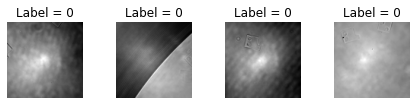

In [5]:
from PIL import Image

train_data = CustomDataset(root='./custom_data/train')
test_data = CustomDataset(root='./custom_data/train')

i = 0
for x, y in train_data:    
    
    img = x
    label = y
    ax = plt.subplot(1, 4, i+1)    
    plt.tight_layout()
    ax.axis('off')
    ax.set_title(f'Label = {label}')    
    imshow(img, cmap='gray')        
    
    if i == 3:                        
        break    
        
    i += 1

In [25]:
learning_rate = 0.001
training_epochs = 15
batch_size = 50

In [26]:
data_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last = True)

for img, label in data_loader:        
    for i in range(batch_size):
        ax = plt.subplot(1, batch_size, i+1)
        ax.axis('off')
        imshow(img[i], cmap='gray')
    print(label)
    break

tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1])


In [27]:
input_size = 200
filter_size = 3
padding = 0
stride = 1

output_size = (input_size - filter_size + (2*padding)) / stride + 1
print(output_size)

198.0


In [28]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(            
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(40000, 2, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)        
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [30]:
model = CNN().to(device)

In [31]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [32]:
print(torch.cuda.get_device_capability())
torch.cuda.empty_cache()

(6, 1)


In [33]:
# Training
total_batch = len(data_loader)

print('Learning Started!')        

for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:

        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
#         print(X.shape)
        X = X.unsqueeze(1)
#         print(X.shape)        
        
        hypothesis = model(X.float())
        
        cost = criterion(hypothesis, Y)        
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print(f'[Epoch:{epoch+1}] cost = {avg_cost}')
    
print('Learning fished!')        

Learning Started!
[Epoch:1] cost = 20468.51953125
[Epoch:2] cost = 2040.6761474609375
[Epoch:3] cost = 204.51416015625
[Epoch:4] cost = 5.831660747528076
[Epoch:5] cost = 2.3721866607666016
[Epoch:6] cost = 2.5161237716674805
[Epoch:7] cost = 1.75763738155365
[Epoch:8] cost = 2.4630587100982666
[Epoch:9] cost = 2.5099971294403076
[Epoch:10] cost = 2.039581060409546
[Epoch:11] cost = 1.9527877569198608
[Epoch:12] cost = 1.604142665863037
[Epoch:13] cost = 1.2009007930755615
[Epoch:14] cost = 1.0480645895004272
[Epoch:15] cost = 1.0263980627059937
Learning fished!


In [34]:
data_loader2 = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True, drop_last = True)

for img, label in data_loader2:        
    for i in range(batch_size):
        ax = plt.subplot(1, batch_size, i+1)
        ax.axis('off')
        imshow(img[i], cmap='gray')
#         print(img[i])
#         print(img[i].shape)
    print(label)
    break

tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
        0, 0])


In [35]:
# model save / load
# PATH = 
# torch.save(model.state_dict(), PATH)

In [36]:
with torch.no_grad():    
    
    model.eval()
    
    total = 0
    correct = 0
    
    for X_test, Y_test in data_loader2:
        X_test = X_test.to(device)
        
        X_test = X_test.unsqueeze(1)
        Y_test = Y_test.to(device)
        
        output = model(X_test.float())
        _, predict = torch.max(output.data, 1)
        
        total += Y_test.size(0)
        correct += (predict==Y_test).sum()
        
    avg_cost = cost / total_batch
    accuracy = 100*correct/total
    
    print(accuracy)

tensor(52.5000, device='cuda:0')


In [ ]:
# Most simple model : VGG 적용해보기
# VGG feature 이미지 보기
# 이후 image processing 해보기